**To make sure that python is used from the newly created enviornment**


In [3]:
import sys
sys.executable

'C:\\Users\\hp India\\anaconda3\\envs\\mlops\\python.exe'

In [4]:
!python --version

Python 3.9.0


### Create functions for all the steps involved in complete model training lifecycle

In [5]:
import pandas as pd
import numpy as np

In [6]:
def load_data(path):
    
    data = pd.read_csv(path)
    return data

In [7]:
data = load_data("https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv")

In [8]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


### Data Pre-processing

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

As we can see, that for this particular dataset, we don't have missing values. But as a good practice, we will create a function to clean data

In [10]:
def data_cleaning(data):
    
    print("Null/missingalues available in the data: \n")
    print(data.isna().sum())
    data = data.dropna()
    print("The data after dropping the na values are: \n")
    print(data.isna().sum())
    
    return data


In [11]:
data['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [12]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [13]:
data.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'], dtype=object)

In [27]:
def preprocessing(data):
    
    data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])
    
    categorical_vars = ['job','marital','education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for var in categorical_vars:
        cat_list = 'var' + '_' + var
        cat_list = pd.get_dummies(data[var], prefix = var)
        data_new = data.join(cat_list)
        data = data_new
    
    categorical_vars = ['job','marital','education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    
    data_vars = data.columns.values.tolist()
    
    keeping = [i for i in data_vars if i not in categorical_vars]
    
    final_df = data[keeping]
    
    final_df.columns = final_df.columns.str.replace(".", "_")
    final_df.columns = final_df.columns.str.replace(" ", "_")
    
    return final_df
    

### Train-Test Split

In [15]:
def train_test_split(final_df):
    from sklearn.model_selection import train_test_split
    X = final_df.loc[:, final_df.columns != 'y']
    y = final_df.loc[:, final_df.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 47)
    
    return X_train, X_test, y_train, y_test

In [16]:
data['y'].value_counts()
# we can see that it is a highly imbalanced dataset

y
0    36548
1     4640
Name: count, dtype: int64

### Over_Sampling the dataset

In [17]:
def over_sampling_target_class(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    
    os = SMOTE(random_state = 0)
    columns = X_train.columns
    
    os_data_X, os_data_y = os.fit_resample(X_train,y_train)
    
    os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
    os_data_y = pd.DataFrame(data = os_data_y, columns = ['y'])
    
    # to check the numbers of the data
    print("The length of the oversampled data is : ", len(os_data_X))
    print("The number of positive class labels in the oversampled data are: ", len(os_data_y[os_data_y['y'] == 1]))
    print("The number of negative class labels in the oversampled data are: ", len(os_data_y[os_data_y['y'] == 0]))
    
    X_train = os_data_X
    y_train = os_data_y['y']
    
    return X_train, y_train


## Experiment-1 (Basic classifier) function 
##### (no hypyerparamater tuning)

In [70]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=150)
    model.fit(X_train, y_train)
    
    return model

In [19]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [20]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

## Evaluation Metrics

In [21]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}


## Visual Evaluation metrics

In [22]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.RocCurveDisplay.from_estimator(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

"\ndef create_confusion_matrix_plot(clf, X_test, y_test):\n    import matplotlib.pyplot as plt\n    from sklearn.metrics import ConfusionMatrixDisplay.from_estimator\n    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)\n    plt.savefig('confusion_matrix.png')\n"

# Experiment 2 (Optimized classifer) 
 ##### (with hyperparameter tuning of Random Forest)

In [79]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [50,65,70,100] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(5, 30, num = 15)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [2, 4, 5] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

## Executing the functions

In [24]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')

In [25]:
cleaned_data = data_cleaning(data)

Null/missingalues available in the data: 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
The data after dropping the na values are: 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [28]:
final_data = preprocessing(cleaned_data)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [30]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

The length of the oversampled data is :  51166
The number of positive class labels in the oversampled data are:  25583
The number of negative class labels in the oversampled data are:  25583


In [71]:
model = training_basic_classifier(X_train,y_train)

In [72]:
y_pred = predict_on_test_data(model,X_test)

In [73]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
y_pred_prob = predict_prob_on_test_data(model,X_test)
y_pred_prob

array([[0.99333333, 0.00666667],
       [1.        , 0.        ],
       [0.95333333, 0.04666667],
       ...,
       [1.        , 0.        ],
       [0.74      , 0.26      ],
       [1.        , 0.        ]])

In [75]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
run_metrics

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.52, 'entropy': 0.2}

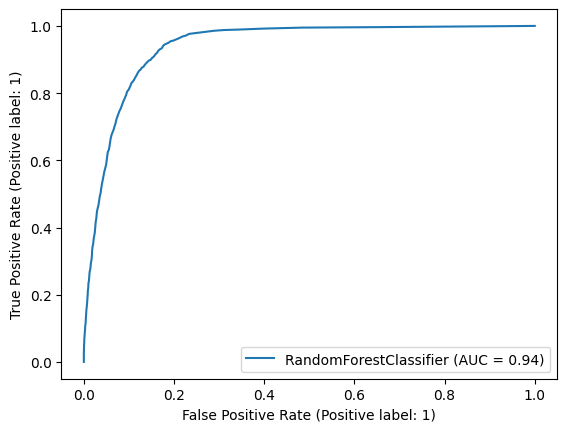

In [76]:
create_roc_auc_plot(model, X_test, y_test)

# MLFlow

In [77]:
experiment_name = "basic_classifier"  #Experiment 1
run_name="term_deposit"

run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.52, 'entropy': 0.2}


In [78]:
create_experiment(experiment_name,run_name,run_metrics,model, 'roc_auc_curve.png')

Run - term_deposit is logged to Experiment - basic_classifier


C:\Users\hp India\anaconda3\envs\mlops\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\hp India\anaconda3\envs\mlops\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Function to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc.

In [39]:
def create_experiment(experiment_name,run_name, run_metrics,model, roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        # we are creating a new run in the active mlflow experiment
        
        
        # log the hyperparameters
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
        
        # for logging the metrics
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
            
        
        mlflow.sklearn.log_model(model, "model")
         
        # we created a png image of the auc curve above, we are logging it as an artifact here    
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))


## Create another experiment after tuning hyperparameters and log the best set of parameters for which model gives the optimal performance

In [80]:
import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\hp India\anaconda3\envs\mlops\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
255 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
198 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp India\anaconda3\envs\mlops\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp India\anaconda3\envs\mlops\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\hp India\anaconda3\envs\mlops\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_const

Random grid:  {'n_estimators': [50, 65, 70, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 6, 8, 10, 12, 13, 15, 17, 19, 21, 22, 24, 26, 28, 30], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [2, 4, 5], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 17, 'bootstrap': True}  



In [89]:
run_metrics

{'accuracy': 0.91, 'precision': 0.61, 'recall': 0.59, 'entropy': 0.19}

In [90]:
for param in run_params:
    print(param, run_params[param])

n_estimators 51
min_samples_split 6
min_samples_leaf 3
max_features sqrt
max_depth 70
bootstrap True


In [2]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned, 'roc_auc_curve.png',run_params)

NameError: name 'create_experiment' is not defined